# HMM Analysis for Andreev State Spectroscopy

This notebook provides functionality for analyzing Andreev state spectroscopy data
using Hidden Markov Models (HMM).

In [1]:
%load_ext autoreload
%autoreload 2


In [37]:
import quasiparticleFunctions as qp
from hmm_utils import (create_physics_based_transition_matrix,
                          get_means_covars)
from hmm_analysis import HMMAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import seaborn as sns

## Single Power at Fixed Flux Workflow

In [14]:
# Initialize analyzer
data_dir = "/Users/shanto/LFL/HMM_Benchmarking/data/"
analyzer = HMMAnalyzer(data_dir, num_modes=2)

new b


In [15]:
# Load data files
analyzer.load_data_files("phi_0p450")

In [16]:
# Process data for specific attenuation
atten = 26
analyzer.load_and_process_data(atten=atten)

In [7]:
%matplotlib qt


Please click on 2 mode centers

Final mode assignments:


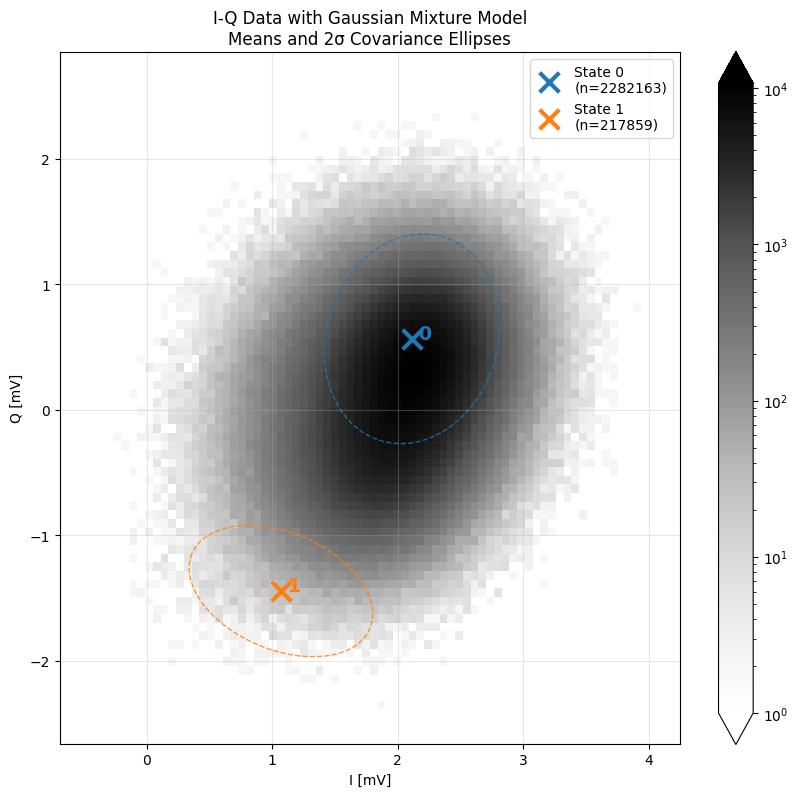

In [8]:
# Get initial parameters
result = get_means_covars(analyzer.data, analyzer.num_modes)
means_guess = result['means']
covars_guess = result['covariances']

In [12]:
means_guess = analyzer.model.means_
covars_guess = analyzer.model.covars_

In [17]:
# Initialize and fit model
analyzer.initialize_model(means_guess, covars_guess)
analyzer.fit_model()

         1    -2626203.8974             +nan
         2    -2237894.8866     +388309.0108
         3    -2213495.8996      +24398.9870
         4    -2207697.3290       +5798.5706
         5    -2206172.1199       +1525.2091
         6    -2205775.0901        +397.0298
         7    -2205671.9778        +103.1123
         8    -2205645.1098         +26.8680
         9    -2205638.0540          +7.0558
        10    -2205636.1789          +1.8751
        11    -2205635.6753          +0.5036
        12    -2205635.5380          +0.1373
        13    -2205635.4999          +0.0380
        14    -2205635.4894          +0.0106
        15    -2205635.4862          +0.0032
        16    -2205635.4853          +0.0008


In [ ]:
# Decode states and calculate probabilities
logprob, states = analyzer.decode_states()
mean_occ, probs = analyzer.calculate_occupation_probabilities(states)
print(f"Mean occupation: {mean_occ}")
print(f"Probabilities: {probs}")

# Save all results and plots
analyzer.save_analysis_results(states, atten, means_guess, covars_guess)

# Calculate SNRs
snrs = analyzer.calculate_snrs()
print("SNRs:", snrs)

Mean occupation: 0.36559198279055144
Probabilities: [0.6344080172094485, 0.36559198279055144]


## Variable Power at Fixed Flux (Bootstrapping) Workflow

In [66]:
def bootstrapping_analysis(analyzer, phi_string, non_linear_atten, snr_threshold):
    analyzer.load_data_files(phi_string)
    attenuations = analyzer.attenuations
    idx = np.where(attenuations == non_linear_atten)[0][0]
    means_guess = None
    covars_guess = None

    results = []  # Collect results for summary plotting

    for i in range(idx, len(attenuations)):
        atten = attenuations[i]
        print(f"\n=== Processing attenuation: {atten} dB ===")
        analyzer.load_and_process_data(atten=atten)
        
        # Get initial parameters for first run, or use previous model's
        if means_guess is None or covars_guess is None:
            result = get_means_covars(analyzer.data, analyzer.num_modes)
            means_guess = result['means']
            covars_guess = result['covariances']
        
        analyzer.initialize_model(means_guess, covars_guess)
        analyzer.fit_model()
        logprob, states = analyzer.decode_states()
        mean_occ, probs = analyzer.calculate_occupation_probabilities(states)
        analyzer.save_analysis_results(states, atten, means_guess, covars_guess)
        snrs = analyzer.calculate_snrs()
        rates = analyzer.calculate_transition_rates()
        
        # Store results
        results.append({
            "atten": atten,
            "mean_occ": mean_occ,
            "probs": probs,
            "snrs": snrs,
            "rates": rates
        })
        
        print(f"Mean occupation: {mean_occ}")
        print(f"Probabilities: {probs}")
        print("SNRs:", snrs)
        
        # Stop if any SNR is below threshold
        if (snrs[0] < snr_threshold):
            print(f"Stopping: SNR below threshold ({snr_threshold})")
            break
        
        # Use current model's means and covariances for next run
        means_guess = analyzer.model.means_
        covars_guess = analyzer.model.covars_

    # Call the summary plotting function
    savepath = analyzer.data_dir
    plot_bootstrap_summary(results, analyzer.num_modes, save_path=savepath)

def plot_bootstrap_summary(results, num_modes, save=True, save_path=None):
    atts = [r["atten"] for r in results]
    mean_occs = [r["mean_occ"] for r in results]
    probs = np.array([r["probs"] for r in results])  # shape: (n, num_modes)
    snrs = np.array([r["snrs"] for r in results])    # shape: (n, num_pairs)
    rates = np.array([r["rates"] for r in results])  # shape: (n, num_modes, num_modes)

    # Plot mean occupation
    plt.figure()
    plt.plot(atts, mean_occs, marker='o')
    plt.xlabel("Attenuation (dB)")
    plt.ylabel("Mean Occupation")
    plt.title("Mean Occupation vs Attenuation")
    plt.grid(True)
    if save:
        plt.savefig(os.path.join(save_path, "mean_occupation.png"))
    plt.show()


    # Plot probabilities
    plt.figure()
    for i in range(num_modes):
        plt.plot(atts, probs[:, i], marker='o', label=f"State {i}")
    plt.xlabel("Attenuation (dB)")
    plt.ylabel("Probability")
    plt.title("State Probabilities vs Attenuation")
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(os.path.join(save_path, "state_probabilities.png"))
    plt.show()

    # Plot SNRs
    plt.figure()
    for i in range(snrs.shape[1]):
        plt.plot(atts, snrs[:, i], marker='o', label=f"SNR {i}")
    plt.xlabel("Attenuation (dB)")
    plt.ylabel("SNR")
    plt.title("SNRs vs Attenuation")
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(os.path.join(save_path, "snrs.png"))
    plt.show()

    # Plot transition rates
    plt.figure()
    for i in range(num_modes):
        for j in range(num_modes):
            if i != j:
                plt.plot(atts, rates[:, i, j], marker='o', label=f"{i}→{j}")
    plt.xlabel("Attenuation (dB)")
    plt.ylabel("Transition Rate (MHz)")
    plt.title("Transition Rates vs Attenuation")
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(os.path.join(save_path, "transition_rates.png"))
    plt.show()

    # Plot transition rates
    plt.figure()
    for i in range(num_modes):
        for j in range(num_modes):
            if i != j:
                plt.plot(atts, rates[:, i, j], marker='o', label=f"{i}→{j}")
    plt.xlabel("Attenuation (dB)")
    plt.ylabel("Transition Rate (MHz)")
    plt.title("Transition Rates vs Attenuation")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(os.path.join(save_path, "transition_rates_log.png"))
    plt.show()

new b

=== Processing attenuation: 26 dB ===

Please click on 2 mode centers

Final mode assignments:


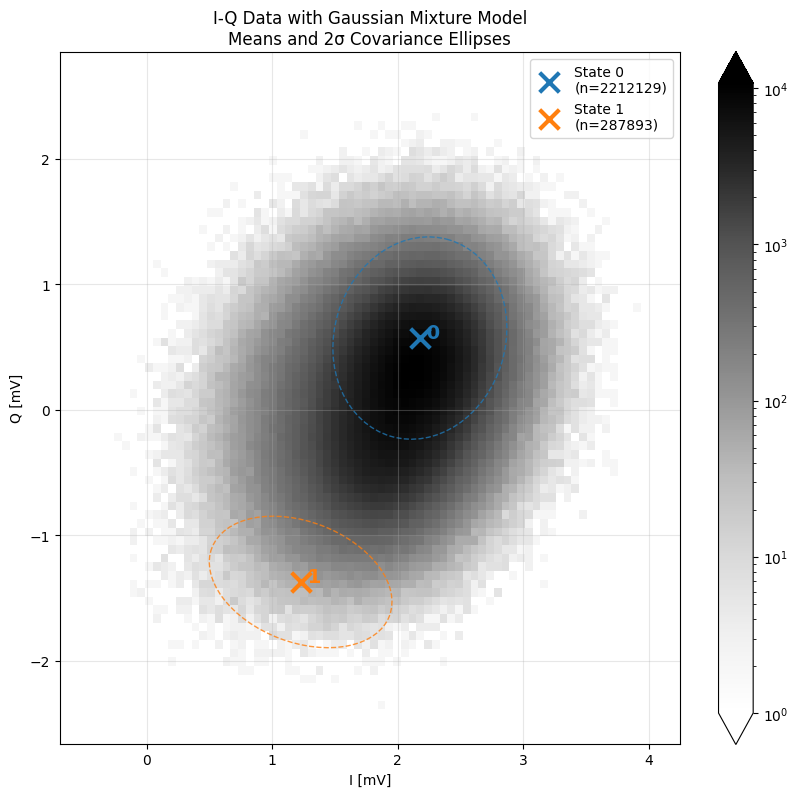

         1    -4326628.4189             +nan
         2    -2723554.4709    +1603073.9480
         3    -2668674.5199      +54879.9510
         4    -2547226.6749     +121447.8450
         5    -2401448.7074     +145777.9675
         6    -2295786.1162     +105662.5913
         7    -2238974.1520      +56811.9641
         8    -2215993.0447      +22981.1073
         9    -2208591.6178       +7401.4270
        10    -2206455.3409       +2136.2769
        11    -2205860.2069        +595.1339
        12    -2205697.0166        +163.1904
        13    -2205652.4177         +44.5989
        14    -2205640.1807         +12.2370
        15    -2205636.8006          +3.3801
        16    -2205635.8577          +0.9429
        17    -2205635.5917          +0.2660
        18    -2205635.5155          +0.0761
        19    -2205635.4939          +0.0217
        20    -2205635.4876          +0.0062
        21    -2205635.4857          +0.0019
        22    -2205635.4852          +0.0006


Mean occupation: 0.36559198279055144
Probabilities: [0.6344080172094485, 0.36559198279055144]
SNRs: [2.45587469]

=== Processing attenuation: 24 dB ===


         1    -4323609.8031             +nan
         2    -2208641.9851    +2114967.8179
         3    -2204810.7159       +3831.2693
         4    -2203552.1514       +1258.5645
         5    -2202493.1058       +1059.0456
         6    -2201539.7661        +953.3396
         7    -2200704.5961        +835.1700
         8    -2200001.7613        +702.8348
         9    -2199437.1437        +564.6176
        10    -2199006.0691        +431.0746
        11    -2198694.0640        +312.0051
        12    -2198479.9801        +214.0840
        13    -2198340.3559        +139.6241
        14    -2198253.3929         +86.9631
        15    -2198201.3387         +52.0542
        16    -2198171.1960         +30.1427
        17    -2198154.1981         +16.9979
        18    -2198144.8088          +9.3892
        19    -2198139.7043          +5.1045
        20    -2198136.9624          +2.7419
        21    -2198135.5015          +1.4609
        22    -2198134.7289          +0.7725
        23

Mean occupation: 0.3428577828515109
Probabilities: [0.6571422171484891, 0.3428577828515109]
SNRs: [0.25215445]
Stopping: SNR below threshold (1.5)


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

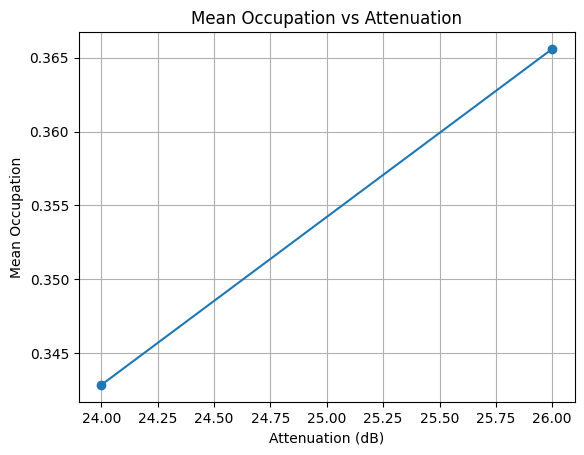

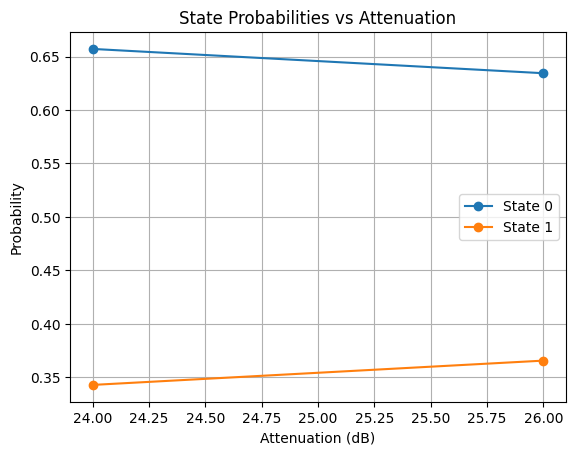

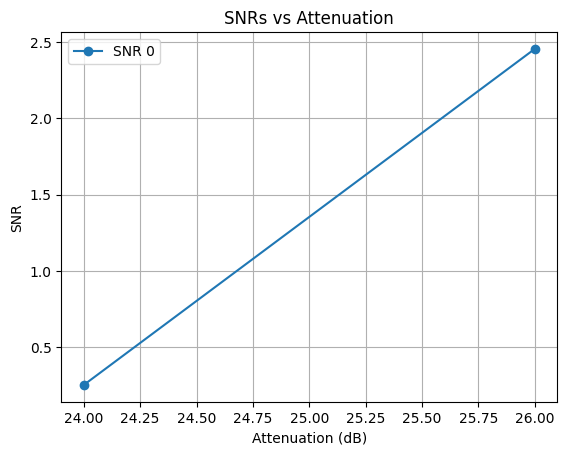

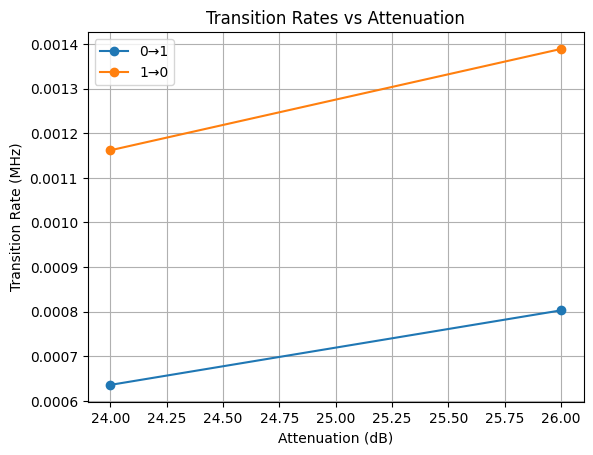

In [41]:
data_dir = "/Users/shanto/LFL/HMM_Benchmarking/data/"
analyzer = HMMAnalyzer(data_dir, num_modes=2)
bootstrapping_analysis(analyzer, "phi_0p450", non_linear_atten=26, snr_threshold=1.5)

## Variable Power and Flux (Bootstrapping) Workflow: *Human-in-the-loop*

In [ ]:
import os
import glob

def analyze_flux_sweep(data_dir, num_modes, non_linear_atten, snr_threshold):
    # Find all phi_* directories
    phi_dirs = sorted(
        [d for d in os.listdir(data_dir) if d.startswith("phi_") and os.path.isdir(os.path.join(data_dir, d))]
    )
    print(f"Found phi directories: {phi_dirs}")

    for phi_string in phi_dirs:
        print(f"\n=== Running analysis for {phi_string} ===")
        analyzer = HMMAnalyzer(data_dir, num_modes=num_modes)
        try:
            bootstrapping_analysis(analyzer, phi_string, non_linear_atten, snr_threshold)
        except Exception as e:
            print(f"Error processing {phi_string}: {e}")

# Usage
data_dir = "/Users/shanto/LFL/HMM_Benchmarking/data/"
analyze_flux_sweep(data_dir, num_modes=2, non_linear_atten=26, snr_threshold=1.5)

## Variable Power and Flux (Bootstrapping) Workflow: *Human-at-Instantiation*


In [67]:
def save_initial_params(phi_dir, non_linear_atten, means, covars, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    fname = f"init_params_{phi_dir}_DA{non_linear_atten}.npz"
    np.savez(os.path.join(save_dir, fname), means=means, covars=covars)
    print(f"Saved initial params for {phi_dir}, DA={non_linear_atten} to {fname}")

def load_initial_params(phi_dir, non_linear_atten, save_dir):
    fname = f"init_params_{phi_dir}_DA{non_linear_atten}.npz"
    data = np.load(os.path.join(save_dir, fname))
    return data['means'], data['covars']

def create_and_save_initial_params(data_dir, phi_dirs, non_linear_attens, num_modes, save_dir):
    """
    For each (phi_dir, non_linear_atten) pair, load the data, let the user select means/covars,
    and save them to disk for later automated use.
    """
    assert len(phi_dirs) == len(non_linear_attens), "phi_dirs and non_linear_attens must have the same length!"
    os.makedirs(save_dir, exist_ok=True)
    
    for phi_dir, atten in zip(phi_dirs, non_linear_attens):
        print(f"\n=== Processing {phi_dir} at DA={atten} ===")
        analyzer = HMMAnalyzer(data_dir, num_modes=num_modes)
        analyzer.load_data_files(phi_dir)
        analyzer.load_and_process_data(atten=atten)
        
        # User selects means and covars (e.g., using a helper or notebook cell)
        # This is where you can plot or inspect the data if needed
        result = get_means_covars(analyzer.data, analyzer.num_modes)
        means_guess = result['means']
        covars_guess = result['covariances']
        
        # Save to disk
        fname = f"init_params_{phi_dir}_DA{atten}.npz"
        np.savez(os.path.join(save_dir, fname), means=means_guess, covars=covars_guess)
        print(f"Saved: {fname}")

def bootstrapping_analysis_auto(analyzer, phi_string, non_linear_atten, snr_threshold, init_param_dir):
    analyzer.load_data_files(phi_string)
    attenuations = analyzer.attenuations
    idx = np.where(attenuations == non_linear_atten)[0][0]
    means_guess, covars_guess = load_initial_params(phi_string, non_linear_atten, init_param_dir)

    results = []
    for i in range(idx, len(attenuations)):
        atten = attenuations[i]
        print(f"\n=== Processing attenuation: {atten} dB ===")
        analyzer.load_and_process_data(atten=atten)
        analyzer.initialize_model(means_guess, covars_guess)
        analyzer.fit_model()
        logprob, states = analyzer.decode_states()
        mean_occ, probs = analyzer.calculate_occupation_probabilities(states)
        analyzer.save_analysis_results(states, atten, means_guess, covars_guess)
        snrs = analyzer.calculate_snrs()
        rates = analyzer.calculate_transition_rates()
        results.append({
            "atten": atten,
            "mean_occ": mean_occ,
            "probs": probs,
            "snrs": snrs,
            "rates": rates
        })
        print(f"Mean occupation: {mean_occ}")
        print(f"Probabilities: {probs}")
        print("SNRs:", snrs)
        if snrs[0] < snr_threshold:
            print(f"Stopping: SNR below threshold ({snr_threshold})")
            break
        means_guess = analyzer.model.means_
        covars_guess = analyzer.model.covars_

        savepath = analyzer.data_dir
        plot_bootstrap_summary(results, analyzer.num_modes, save_path=savepath)

def analyze_flux_sweep_auto(data_dir, num_modes, phi_dirs, non_linear_attens, snr_threshold, init_param_dir):
    assert len(phi_dirs) == len(non_linear_attens), "Length of phi_dirs and non_linear_attens must match!"
    for phi_string, non_linear_atten in zip(phi_dirs, non_linear_attens):
        print(f"\n=== Running analysis for {phi_string} (DA={non_linear_atten}) ===")
        analyzer = HMMAnalyzer(data_dir, num_modes=num_modes)
        try:
            bootstrapping_analysis_auto(analyzer, phi_string, non_linear_atten, snr_threshold, init_param_dir)
        except Exception as e:
            print(f"Error processing {phi_string}: {e}")

In [62]:
data_dir = "/Users/shanto/LFL/HMM_Benchmarking/data/"
init_param_dir = "/Users/shanto/LFL/HMM_Benchmarking/initial_params/"
phi_dirs = sorted([d for d in os.listdir(data_dir) if d.startswith("phi_") and os.path.isdir(os.path.join(data_dir, d))])
phi_dirs

['phi_0p450']

In [63]:
non_linear_attens = [22]


=== Processing phi_0p450 at DA=22 ===
new b

Please click on 3 mode centers

Final mode assignments:


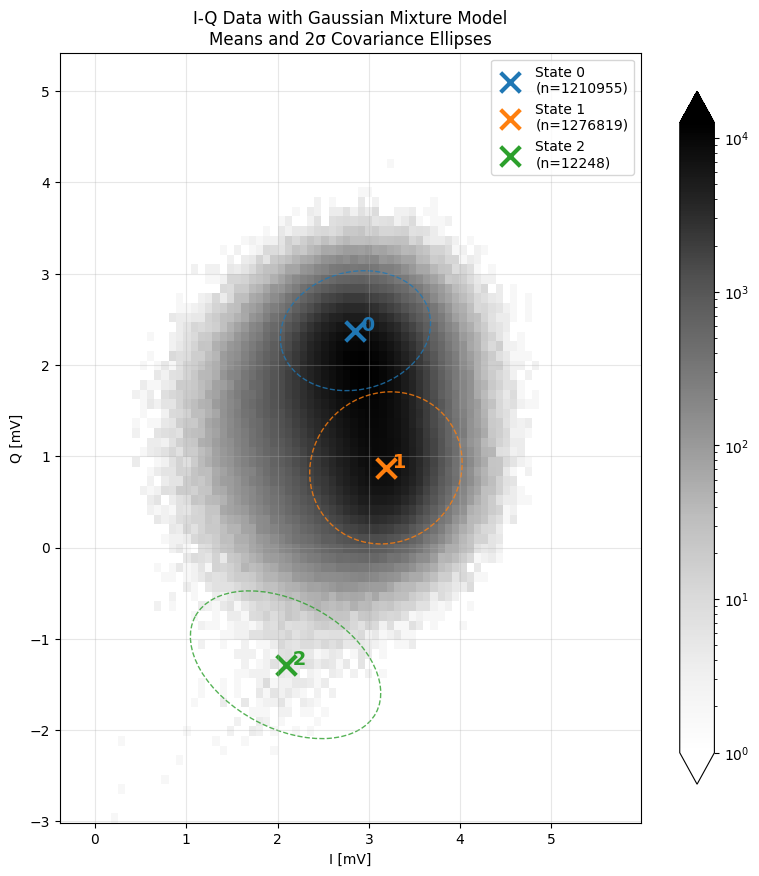

Saved: init_params_phi_0p450_DA22.npz


In [64]:
create_and_save_initial_params(data_dir, phi_dirs, non_linear_attens, num_modes=3, save_dir=init_param_dir)


=== Running analysis for phi_0p450 (DA=22) ===
new b

=== Processing attenuation: 22 dB ===


         1    -4045893.0064             +nan
         2    -2990255.6616    +1055637.3448
         3    -2956855.4653      +33400.1963
         4    -2942119.1493      +14736.3161
         5    -2934895.9456       +7223.2037
         6    -2930787.4115       +4108.5340
         7    -2928034.1905       +2753.2211
         8    -2926037.3773       +1996.8132
         9    -2924539.2531       +1498.1241
        10    -2923392.2138       +1147.0393
        11    -2922499.0767        +893.1372
        12    -2921791.5024        +707.5743
        13    -2921221.2514        +570.2510
        14    -2920754.3044        +466.9470
        15    -2920366.4871        +387.8173
        16    -2920040.3070        +326.1800
        17    -2919762.9103        +277.3968
        18    -2919524.6495        +238.2608
        19    -2919318.1804        +206.4691
        20    -2919137.8184        +180.3620
        21    -2918979.1289        +158.6895
        22    -2918838.5960        +140.5328
        23

Mean occupation: 0.4519300230157975
Probabilities: [0.5967815483223747, 0.354506880339453, 0.04871157133817222]
SNRs: [5.51789483 4.96867225 0.61706842]

=== Processing attenuation: 20 dB ===


         1   -33897301.3342             +nan
         2    -3488385.2672   +30408916.0671
         3    -3486525.8234       +1859.4438
         4    -3483471.0661       +3054.7573
         5    -3475441.8890       +8029.1771
         6    -3462955.9000      +12485.9890
         7    -3447674.0638      +15281.8362
         8    -3400616.4483      +47057.6155
         9    -3257485.2507     +143131.1976
        10    -3103835.8769     +153649.3738
        11    -2999943.4384     +103892.4386
        12    -2951251.6119      +48691.8265
        13    -2935399.5120      +15852.0999
        14    -2931066.6764       +4332.8356
        15    -2929791.9493       +1274.7271
        16    -2929337.6509        +454.2985
        17    -2929129.8179        +207.8330
        18    -2929011.7447        +118.0732
        19    -2928935.6120         +76.1327
        20    -2928883.5137         +52.0983
        21    -2928846.8185         +36.6952
        22    -2928820.5388         +26.2796
        23

Mean occupation: 0.8846282152717057
Probabilities: [0.5125074899340886, 0.09035680486011723, 0.39713570520579417]
SNRs: [2.02932361 2.40542024 0.97429038]

=== Processing attenuation: 18 dB ===


         1    -9931258.1325             +nan
         2    -3192079.8907    +6739178.2418
         3    -3185747.0420       +6332.8487
         4    -3182498.5841       +3248.4580
         5    -3180477.8359       +2020.7482
         6    -3179023.3540       +1454.4818
         7    -3177586.9720       +1436.3821
         8    -3176048.9375       +1538.0345
         9    -3174367.5957       +1681.3418
        10    -3172394.8495       +1972.7462
        11    -3170016.7565       +2378.0930
        12    -3167125.6054       +2891.1511
        13    -3163615.3546       +3510.2508
        14    -3159401.8405       +4213.5140
        15    -3154454.8602       +4946.9804
        16    -3148827.2294       +5627.6307
        17    -3142653.8981       +6173.3313
        18    -3136125.5742       +6528.3239
        19    -3129462.6731       +6662.9011
        20    -3122880.4819       +6582.1912
        21    -3116552.4879       +6327.9940
        22    -3110593.2872       +5959.2007
        23

Mean occupation: 0.8931505402752455
Probabilities: [0.49796961786736277, 0.1109102239900289, 0.39112015814260837]
SNRs: [0.75477741 0.35215576 1.08216164]
Stopping: SNR below threshold (1.5)


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

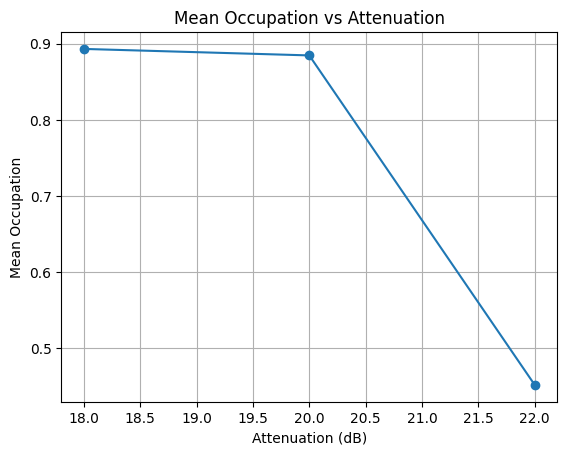

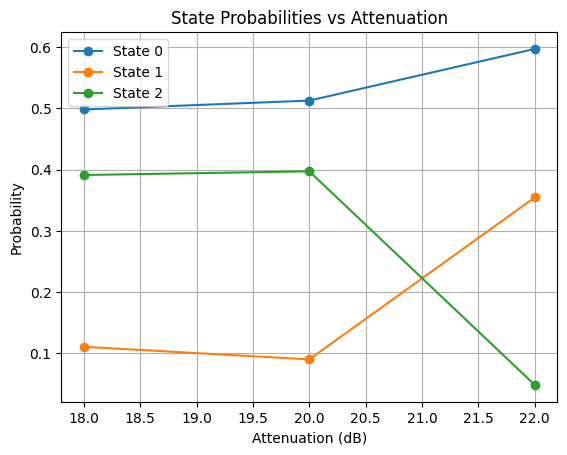

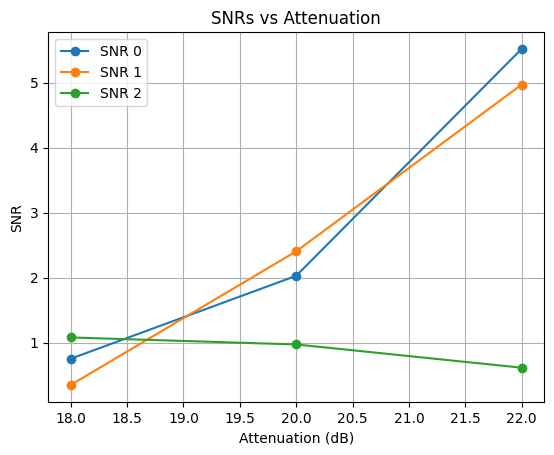

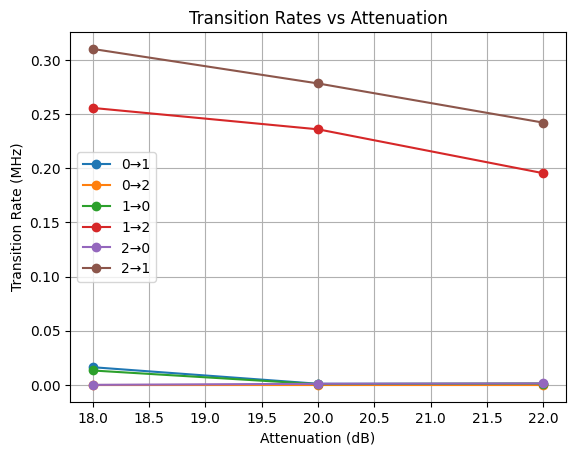

In [65]:
analyze_flux_sweep_auto(data_dir, num_modes=3, phi_dirs=phi_dirs, non_linear_attens=non_linear_attens, snr_threshold=1.5, init_param_dir=init_param_dir)